# IMPORT LIBRARIES

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D, Dense, Input, Concatenate
from tensorflow.keras.models import Model
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from tensorflow.keras.optimizers import Adam
import pickle

In [2]:
df = pd.read_csv("imdb_top_1000.csv")

In [3]:
df.columns

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')

In [4]:
movie_df = df[['Series_Title','Genre','Overview','IMDB_Rating','Meta_score']]

# EDA

In [5]:
movie_df

,Series_Title,Genre,Overview,IMDB_Rating,Meta_score
0,The Shawshank Redemption,Drama,Two imprisoned men bond over a number of years...,9.3,80.0
1,The Godfather,"Crime, Drama",An organized crime dynasty's aging patriarch t...,9.2,100.0
2,The Dark Knight,"Action, Crime, Drama",When the menace known as the Joker wreaks havo...,9.0,84.0
3,The Godfather: Part II,"Crime, Drama",The early life and career of Vito Corleone in ...,9.0,90.0
4,12 Angry Men,"Crime, Drama",A jury holdout attempts to prevent a miscarria...,9.0,96.0
...,...,...,...,...,...
995,Breakfast at Tiffany's,"Comedy, Drama, Romance",A young New York socialite becomes interested ...,7.6,76.0
996,Giant,"Drama, Western",Sprawling epic covering the life of a Texas ca...,7.6,84.0
997,From Here to Eternity,"Drama, Romance, War","In Hawaii in 1941, a private is cruelly punish...",7.6,85.0
998,Lifeboat,"Drama, War",Several survivors of a torpedoed merchant ship...,7.6,78.0


In [6]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Series_Title  1000 non-null   object 
 1   Genre         1000 non-null   object 
 2   Overview      1000 non-null   object 
 3   IMDB_Rating   1000 non-null   float64
 4   Meta_score    843 non-null    float64
dtypes: float64(2), object(3)
memory usage: 39.2+ KB


In [7]:
movie_df.dropna(inplace=True)

C:\Users\Asus\AppData\Local\Temp\ipykernel_27912\715468614.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df.dropna(inplace=True)


In [8]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 843 entries, 0 to 999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Series_Title  843 non-null    object 
 1   Genre         843 non-null    object 
 2   Overview      843 non-null    object 
 3   IMDB_Rating   843 non-null    float64
 4   Meta_score    843 non-null    float64
dtypes: float64(2), object(3)
memory usage: 39.5+ KB


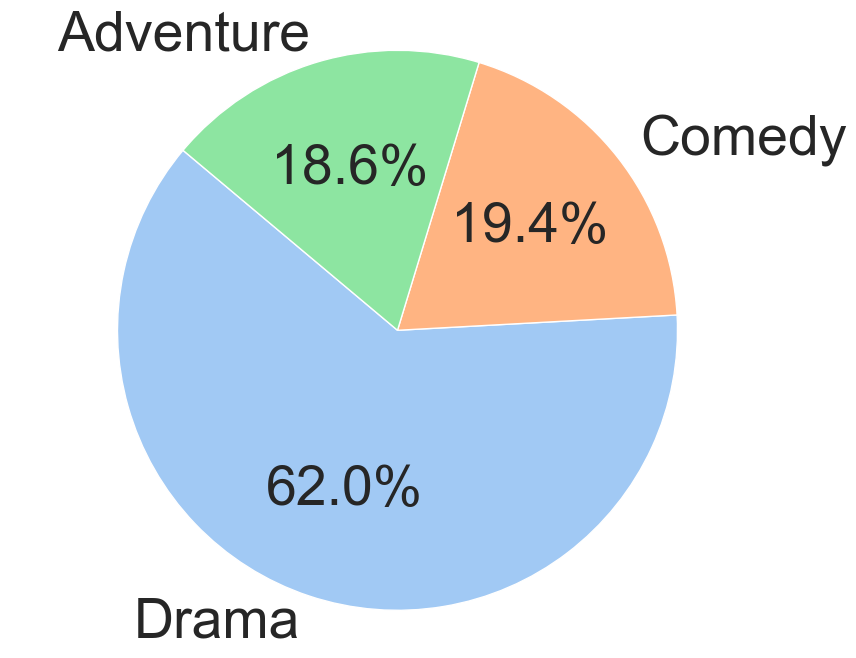

In [17]:
tmp_df = movie_df.copy()
tmp_df['Genre'] = movie_df['Genre'].str.split(', ')
tmp_exp = tmp_df.explode('Genre')
genre_cnt = tmp_exp['Genre'].value_counts().nlargest(3)

plt.figure(figsize=(10, 8))
sns.set_palette("pastel")
sns.set_style("whitegrid")
# plt.title('Top 3 Most Frequent Genres', fontsize=20)
plt.pie(genre_cnt, labels=genre_cnt.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 40})
plt.axis('equal')
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_9536\1046443508.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Series_Title', y='Combined_Score', data=top_comb, palette='BuGn')


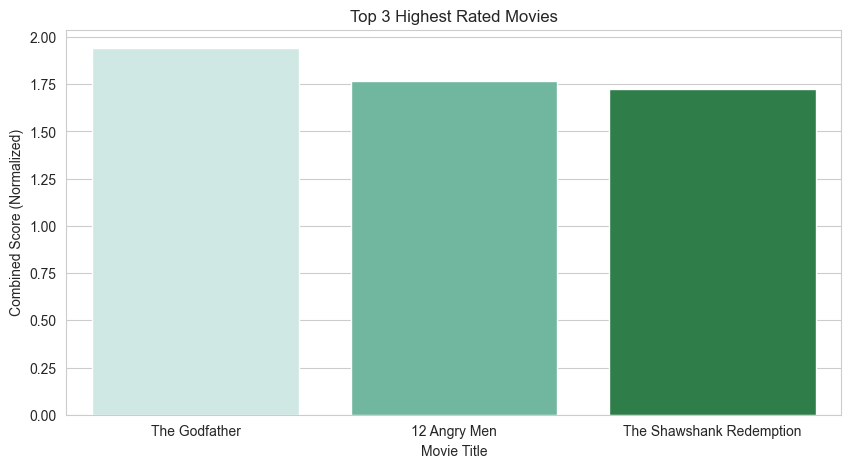

In [10]:
scaler = MinMaxScaler()
tmp_df[['IMDB_Rating', 'Meta_score']] = scaler.fit_transform(tmp_df[['IMDB_Rating', 'Meta_score']])
tmp_df['Combined_Score'] = tmp_df['IMDB_Rating'] + tmp_df['Meta_score']
top_comb = tmp_df.nlargest(3,'Combined_Score')

plt.figure(figsize=(10, 5))
sns.barplot(x='Series_Title', y='Combined_Score', data=top_comb, palette='BuGn')
plt.title('Top 3 Highest Rated Movies')
plt.xlabel('Movie Title')
plt.ylabel('Combined Score (Normalized)')
plt.show()

# Preprocess

In [11]:
scaler = MinMaxScaler()
movie_df[['IMDB_Rating', 'Meta_score']] = scaler.fit_transform(movie_df[['IMDB_Rating', 'Meta_score']])

C:\Users\Asus\AppData\Local\Temp\ipykernel_9536\1482965611.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df[['IMDB_Rating', 'Meta_score']] = scaler.fit_transform(movie_df[['IMDB_Rating', 'Meta_score']])


In [12]:
movie_df['Content'] = movie_df['Genre'] + ' ' + movie_df['Overview']

C:\Users\Asus\AppData\Local\Temp\ipykernel_9536\2629692574.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df['Content'] = movie_df['Genre'] + ' ' + movie_df['Overview']


In [13]:
train_df, test_df = train_test_split(movie_df, test_size=0.2, random_state=42)

In [14]:
vectorizer = TextVectorization(max_tokens=5000, output_mode='int', output_sequence_length=500)
vectorizer.adapt(train_df['Content'])
train_content_sequences = vectorizer(train_df['Content'])
test_content_sequences = vectorizer(test_df['Content'])

# MODEL BUILDING

In [15]:
content_input = Input(shape=(500,), dtype=tf.int64, name='content_input')
embedding_layer = Embedding(input_dim=5000, output_dim=64)(content_input)
pooling_layer = GlobalAveragePooling1D()(embedding_layer)

In [16]:
additional_features_input = Input(shape=(2,), name='additional_features')
concatenated = Concatenate()([pooling_layer, additional_features_input])
output_layer = Dense(2, activation='linear')(concatenated)
model = Model(inputs=[content_input, additional_features_input], outputs=output_layer)
model.compile(optimizer=Adam(), loss='mean_squared_error',metrics=['accuracy'])

In [17]:
train_additional_features = train_df[['IMDB_Rating', 'Meta_score']].values
test_additional_features = test_df[['IMDB_Rating', 'Meta_score']].values

In [18]:
train_additional_features

array([[0.11764706, 0.73611111],
       [0.        , 0.02777778],
       [0.11764706, 0.40277778],
       ...,
       [0.23529412, 0.63888889],
       [0.17647059, 0.84722222],
       [0.41176471, 1.        ]])

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9814 - loss: 0.0020 - val_accuracy: 0.9704 - val_loss: 0.0039
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9876 - loss: 0.0018 - val_accuracy: 0.9704 - val_loss: 0.0038
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9730 - loss: 0.0017 - val_accuracy: 0.9704 - val_loss: 0.0033
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9856 - loss: 0.0017 - val_accuracy: 0.9704 - val_loss: 0.0028
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9859 - loss: 0.0015 - val_accuracy: 0.9704 - val_loss: 0.0027
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9764 - loss: 0.0012 - val_accuracy: 0.9704 - val_loss: 0.0027
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9928 - loss: 9.2963e-04 - val_accuracy: 0.9704 - val_loss: 0.0024
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9822 - loss: 9.0593e-04 - val_accuracy: 0.9704 - 

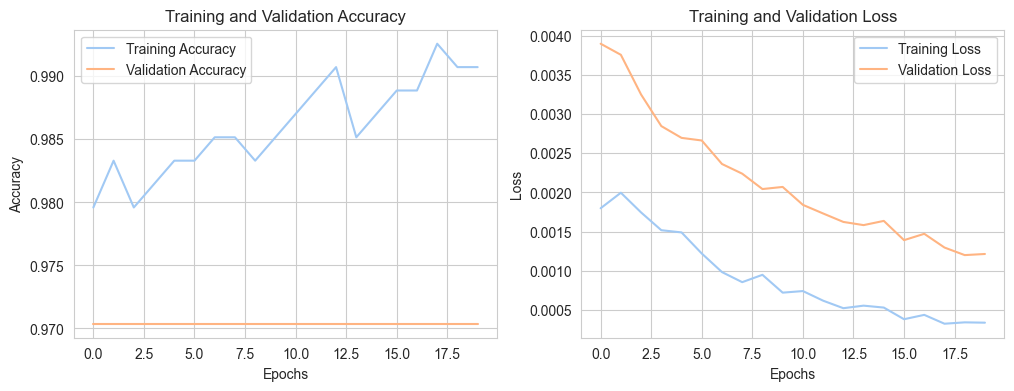

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ content_input       │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 500, 64)   │    320,000 │ content_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ embedding[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additional_features │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 66)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ additional_featu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │        134 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 960,404 (3.66 MB)

 Trainable params: 320,134 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 640,270 (2.44 MB)

In [27]:
history = model.fit(
    [train_content_sequences, train_additional_features],
    train_additional_features,
    epochs=20,
    batch_size=10,
    validation_split=0.2
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

model.summary()


In [28]:
embeddings_model = Model(inputs=model.input, outputs=model.layers[-3].output)
test_embeddings = embeddings_model.predict([test_content_sequences, test_additional_features])
normalized_test_embeddings = test_embeddings / np.linalg.norm(test_embeddings, axis=1, keepdims=True)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [32]:
predicted_additional_features = model.predict([test_content_sequences, test_additional_features])
mse = mean_squared_error(test_additional_features, predicted_additional_features)
mae = mean_absolute_error(test_additional_features, predicted_additional_features)
r_2  = r2_score(test_additional_features, predicted_additional_features)
print(f'Mean Squared Error on Test Set: {mse}')
print(f'Mean Average Error on Test Set: {mae}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Squared Error on Test Set: 0.0011631017156878026
Mean Average Error on Test Set: 0.027150795406351014


# RECOMMENDATION FUNCTION

In [30]:
def recommend_movies(movie_name, movie_df, vectorizer, embeddings_model, top_n=10):
    input_movie = movie_df[movie_df['Series_Title'] == movie_name]
    
    if input_movie.empty:
        return f"Movie '{movie_name}' not found in the dataset."
    
    input_content = input_movie['Content'].values[0]
    input_content_sequence = vectorizer(tf.convert_to_tensor([input_content]))
    input_embedding = embeddings_model.predict([input_content_sequence, input_movie[['IMDB_Rating', 'Meta_score']].values])
    input_embedding = input_embedding / np.linalg.norm(input_embedding, axis=1, keepdims=True)
    all_embeddings = embeddings_model.predict([vectorizer(movie_df['Content']), movie_df[['IMDB_Rating', 'Meta_score']].values])
    all_embeddings = all_embeddings / np.linalg.norm(all_embeddings, axis=1, keepdims=True)
    
    cosine_similarities = np.dot(all_embeddings, input_embedding.T).flatten()
    similar_indices = np.argsort(cosine_similarities)[::-1][1:top_n+1]
    similar_movies = movie_df.iloc[similar_indices]
    
    return similar_movies

recommended_movies = recommend_movies("The Shawshank Redemption", movie_df, vectorizer, embeddings_model)
recommended_movies

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step


,Series_Title,Genre,Overview,IMDB_Rating,Meta_score,Content
26,La vita è bella,"Comedy, Drama, Romance",When an open-minded Jewish librarian and his s...,0.588235,0.430556,"Comedy, Drama, Romance When an open-minded Jew..."
9,Fight Club,Drama,An insomniac office worker and a devil-may-car...,0.705882,0.527778,Drama An insomniac office worker and a devil-m...
35,The Intouchables,"Biography, Comedy, Drama",After he becomes a quadriplegic from a paragli...,0.529412,0.402778,"Biography, Comedy, Drama After he becomes a qu..."
25,The Green Mile,"Crime, Drama, Fantasy",The lives of guards on Death Row are affected ...,0.588235,0.458333,"Crime, Drama, Fantasy The lives of guards on D..."
33,Joker,"Crime, Drama, Thriller","In Gotham City, mentally troubled comedian Art...",0.529412,0.430556,"Crime, Drama, Thriller In Gotham City, mentall..."
27,Se7en,"Crime, Drama, Mystery","Two detectives, a rookie and a veteran, hunt a...",0.588235,0.513889,"Crime, Drama, Mystery Two detectives, a rookie..."
40,American History X,Drama,A former neo-nazi skinhead tries to prevent hi...,0.529412,0.472222,Drama A former neo-nazi skinhead tries to prev...
272,Pink Floyd: The Wall,"Drama, Fantasy, Music",A confined but troubled rock star descends int...,0.294118,0.263889,"Drama, Fantasy, Music A confined but troubled ..."
8,Inception,"Action, Adventure, Sci-Fi",A thief who steals corporate secrets through t...,0.705882,0.638889,"Action, Adventure, Sci-Fi A thief who steals c..."
96,Snatch,"Comedy, Crime","Unscrupulous boxing promoters, violent bookmak...",0.411765,0.375000,"Comedy, Crime Unscrupulous boxing promoters, v..."


In [31]:
model.save('movie_recommendation_model.h5')

vectorizer_model_path = 'vectorizer.pkl'
with open(vectorizer_model_path, 'wb') as f:
    pickle.dump(vectorizer, f)

scaler_model_path = 'scaler.pkl'
with open(scaler_model_path, 'wb') as f:
    pickle.dump(scaler, f)